In [75]:
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

url = "http://37.9.3.250/download/files.synop/27/27514.01.01.2016.01.01.2022.1.0.0.ru.utf8.00000000.csv.gz"
filename = "weather.csv.gz"
urllib.request.urlretrieve(url, filename)

('weather.csv.gz', <http.client.HTTPMessage at 0x19eaf0c9760>)

In [2]:
data = pd.read_csv(filename, skiprows=6, encoding='utf-8', compression='gzip', sep=';', index_col=False)

In [3]:
data.head(3)

,Местное время в Шереметьево / им. А. С. Пушкина (аэропорт),T,Po,P,Pa,U,DD,Ff,ff10,ff3,...,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
0,01.01.2022 21:00,-3.1,734.7,752.3,NaN,89,"Ветер, дующий с северо-запада",4,NaN,NaN,...,Высокослоистые непросвечивающие или слоисто-до...,NaN,NaN,-4.7,0.4,12.0,NaN,NaN,NaN,NaN
1,01.01.2022 18:00,-2.6,734.1,751.6,NaN,84,"Ветер, дующий с севера",3,NaN,NaN,...,NaN,NaN,10.0,-4.9,NaN,NaN,NaN,NaN,NaN,NaN
2,01.01.2022 15:00,-1.4,733.2,750.6,NaN,83,"Ветер, дующий с северо-запада",4,NaN,NaN,...,NaN,NaN,10.0,-3.9,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data['date'] = pd.to_datetime(data['Местное время в Шереметьево / им. А. С. Пушкина (аэропорт)'], dayfirst=True)

In [464]:
data.shape

(15728, 34)

In [5]:
data['dayofyear'] = data['date'].dt.dayofyear

In [410]:
# Checking the missing values. Getting data prepared. Visualization of the temperature dependence on the day of the year.

In [360]:
data.isnull().sum()

Местное время в Шереметьево / им. А. С. Пушкина (аэропорт)        0
T                                                                 0
Po                                                              105
P                                                                 0
Pa                                                            14775
U                                                                 0
DD                                                                1
Ff                                                                0
ff10                                                          13919
ff3                                                            9634
N                                                                 0
WW                                                                0
W1                                                             8114
W2                                                             8114
Tn                                              

In [7]:
data = data.dropna(subset=['T'])

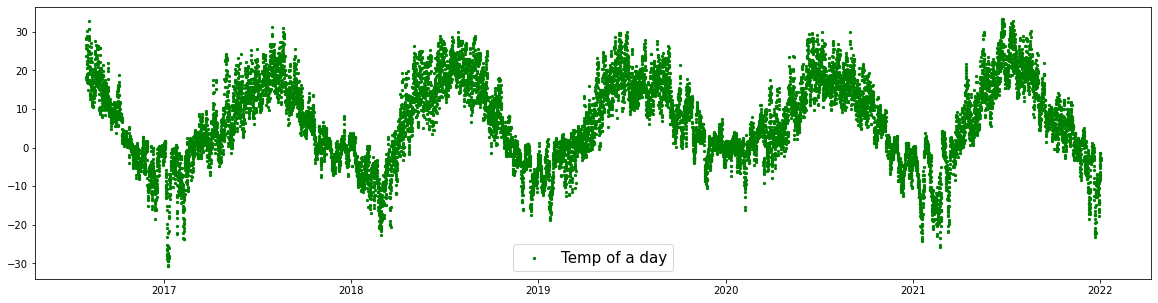

In [220]:
plt.figure(figsize=(20, 5))
plt.scatter(data['date'], data['T'],s=5, color='green', label='Temp of a day')
plt.legend(loc = 'lower center', prop={'size': 15})

In [411]:
# As we can see, this is most similar to the cos or sin function.

<AxesSubplot:>

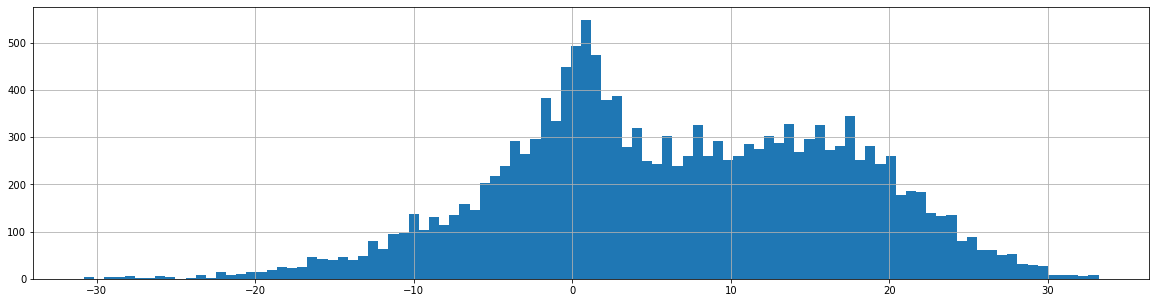

In [365]:
data['T'].hist(figsize=(20, 5), bins = 100)

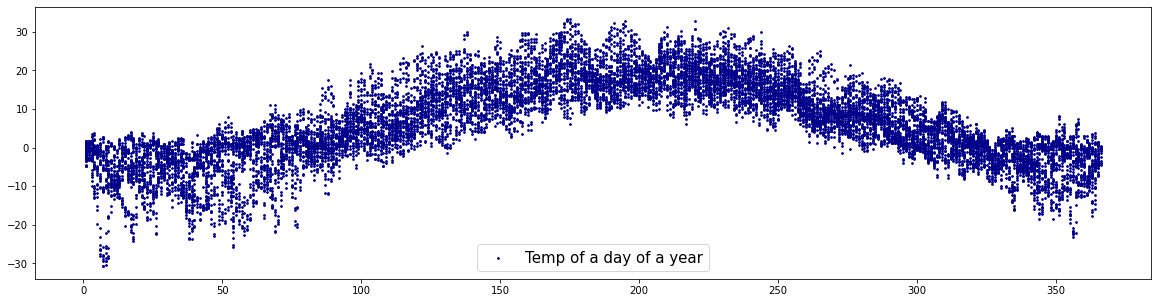

In [366]:
plt.figure(figsize=(20, 5))
plt.scatter(data['dayofyear'], data['T'], s=3, color='darkblue', label='Temp of a day of a year')
plt.legend(loc = 'lower center', prop={'size': 15})

In [432]:
# Our basic model uses both functions at once - cos and sin.

In [433]:
# We adapt cos to the period of our data.
data['cos_dayofyear'] = np.cos((data['dayofyear'] - 1) / 366 * 2* np.pi)
data['sin_dayofyear'] = np.sin((data['dayofyear'] - 1) / 366 * 2* np.pi)

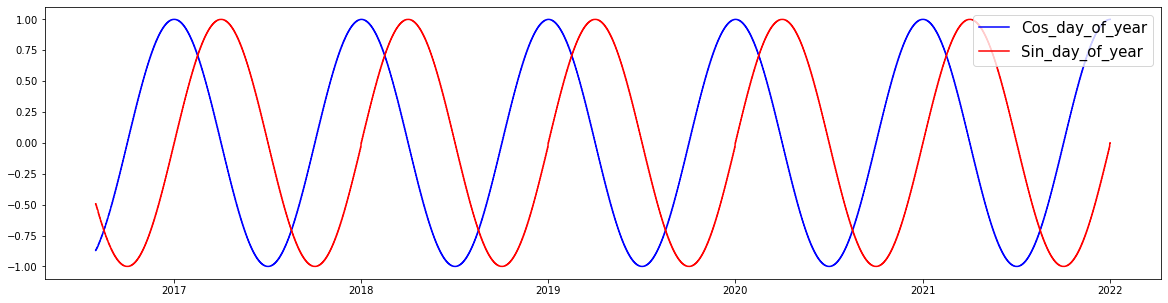

In [243]:
plt.figure(figsize=(20, 5))
plt.plot(data['date'], data['cos_dayofyear'],  color='blue', label='Cos_day_of_year')
plt.plot(data['date'], data['sin_dayofyear'],  color='red',  label='Sin_day_of_year')
plt.legend(loc = 'upper right', prop={'size': 15})

In [431]:
# Since we are dealing with a time series, instead of randomly splitting the data, we will simply make a cutoff on one of the dates.

In [43]:
data_train = data[data['date'] < '2020-01-01']
data_test = data[data['date'] >= '2020-01-01']

In [435]:
ratio_of_testing_sample = f'{round(data_test.shape[0]/data.shape[0] * 100, 1)}%'

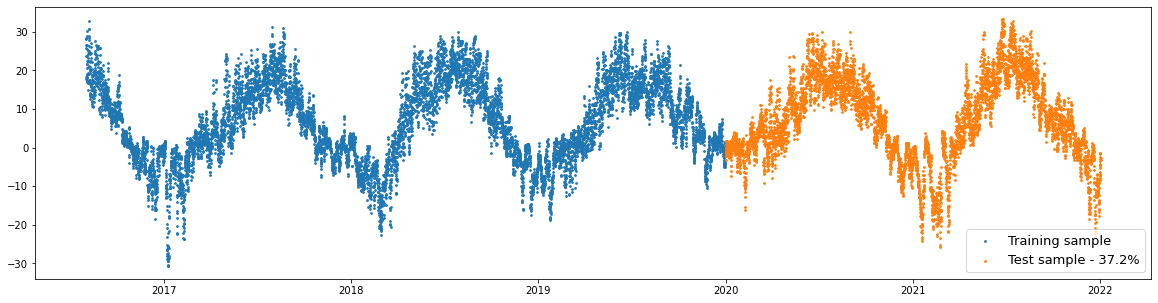

In [438]:
plt.figure(figsize=(20, 5))
plt.scatter(data_train['date'], data_train['T'], s=3, label='Training sample')
plt.scatter(data_test['date'], data_test['T'], s=3, label=f'Test sample - {ratio_of_testing_sample}')
plt.legend(loc = 'lower right', prop={'size': 13})

In [76]:
X_train = data_train[['cos_dayofyear', 'sin_dayofyear']]
X_test = data_test[['cos_dayofyear', 'sin_dayofyear']]
y_train = data_train['T']
y_test = data_test['T']

In [77]:
model_lin = LinearRegression()

In [78]:
model_lin.fit(X_train, y_train)

LinearRegression()

In [79]:
pred_train = model_lin.predict(X_train)
pred_test = model_lin.predict(X_test)

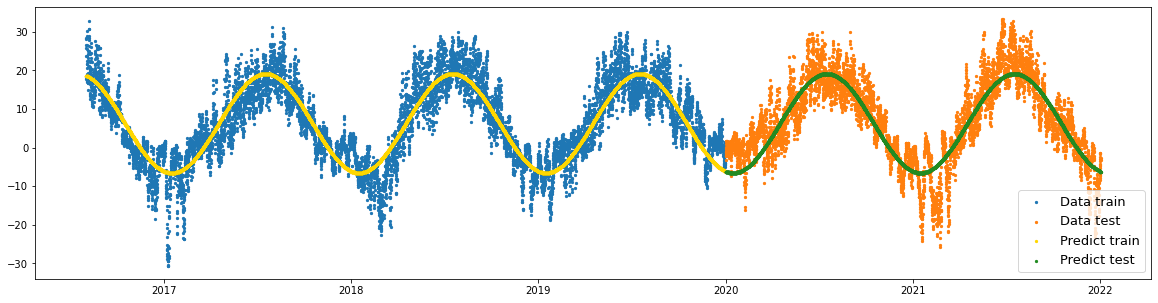

In [465]:
plt.figure(figsize=(20, 5))
plt.scatter(data_train['date'], y_train, s=5, label='Data train')
plt.scatter(data_test['date'], y_test, s=5, label='Data test')
plt.scatter(data_train['date'], pred_train, s=5, color='gold', label='Predict train')
plt.scatter(data_test['date'], pred_test, s=5,color='forestgreen', label='Predict test')
plt.legend(loc = 'lower right', prop={'size': 13})

In [385]:
print('Mean error on training sample =', mean_absolute_error(y_train, pred_train).round(2))
print('Mean error on test sample =', mean_absolute_error(y_test, pred_test).round(2))

Mean error on training sample = 4.02
Mean error on test sample = 4.25


In [386]:
#checking the significance of coef
mod = sm.OLS(y_train, X_train)
fii = mod.fit()
p_values = fii.summary2().tables[1]['P>|t|']
pd.DataFrame(p_values.map(int))

,P>|t|
cos_dayofyear,0
sin_dayofyear,0


In [441]:
score = model_lin.score(X_train, y_train).round(2)
print(f'Coefficient of determination = {score}')

Coefficient of determination = 0.76


In [445]:
# Model 1 uses cos, sin + new features that doesnt contain missing values.
# P - Atmospheric pressure in millimeters of mercury
# U - Relative humidity (%) at an altitude of 2 meters above ground level.
# Ff - Wind speed at an altitude of 10-12 meters above the ground level.
# Td - The dew point temperature (in degrees Celsius) at an altitude of 2 meters above ground level.

In [248]:
X_train_1 = data_train[['cos_dayofyear', 'sin_dayofyear', 'P', 'U', 'Ff', 'Td']]
X_test_1 = data_test[['cos_dayofyear', 'sin_dayofyear', 'P', 'U', 'Ff', 'Td']]
y_train_1 = data_train['T']
y_test_1 = data_test['T']

In [249]:
model_lin_1 = LinearRegression()

In [250]:
model_lin_1.fit(X_train_1, y_train_1)

LinearRegression()

In [251]:
pred_train_1 = model_lin_1.predict(X_train_1)
pred_test_1 = model_lin_1.predict(X_test_1)

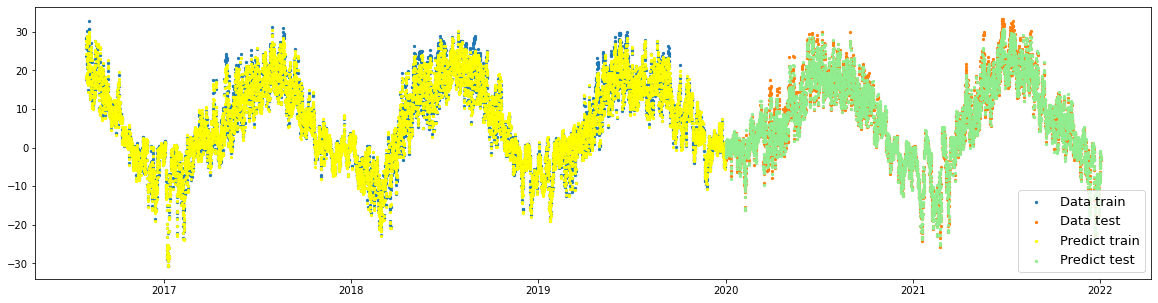

In [291]:
plt.figure(figsize=(20, 5))
plt.scatter(data_train_1['date'], y_train_1, s=5, label='Data train')
plt.scatter(data_test_1['date'], y_test_1, s=5, label='Data test')
plt.scatter(data_train_1['date'], pred_train_1, s=5, color='yellow', label='Predict train')
plt.scatter(data_test_1['date'], pred_test_1, s=5,color='lightgreen', label='Predict test')
plt.legend(loc = 'lower right', prop={'size': 13})

In [384]:
print('Mean error on training sample 1 =', mean_absolute_error(y_train_1, pred_train_1).round(2))
print('Mean error on test sample 1 =', mean_absolute_error(y_test_1, pred_test_1).round(2))

Mean error on training sample 1 = 0.53
Mean error on test sample 1 = 0.56


In [340]:
#checking the significance of coef
mod_1 = sm.OLS(y_train_1, X_train_1)
fii_1 = mod_1.fit()
p_values_1 = fii_1.summary2().tables[1]['P>|t|']
pd.DataFrame(p_values_1.map(int))

,P>|t|
cos_dayofyear,0
sin_dayofyear,0
P,0
U,0
Ff,0
Td,0


In [443]:
score_1 = model_lin_1.score(X_train_1, y_train_1).round(2)
print(f'Coefficient of determination = {score_1}')

Coefficient of determination = 1.0


In [446]:
# We can predict the temperature with high accuracy, but we need the data of the current day.  It is an intraday prediction.
# To solve this issue we can try to use the median values of months.
# Model 2 uses model 1 feautures with replacing current data to median data (except cos and sin).

In [256]:
data['month'] = data['date'].dt.month

In [258]:
data_month = (
    data[data['date'] < '2020-01-01'].groupby('month', as_index=False)
    .agg({'P' : 'median', 'U' : 'median', 'Ff' : 'median', 'Td' : 'median'})
    .rename(columns={'P' : 'med_P', 'U' : 'med_U', 'Ff' : 'med_Ff', 'Td' : 'med_Td'})
)

In [307]:
data_2 = data[['T', 'date', 'month', 'cos_dayofyear', 'sin_dayofyear']].merge(data_month, on='month')

In [327]:
data_2.head(3)

,T,date,month,cos_dayofyear,sin_dayofyear,med_P,med_U,med_Ff,med_Td
0,-3.1,2022-01-01 21:00:00,1,1.0,0.0,761.4,88.0,4.0,-8.1
1,-2.6,2022-01-01 18:00:00,1,1.0,0.0,761.4,88.0,4.0,-8.1
2,-1.4,2022-01-01 15:00:00,1,1.0,0.0,761.4,88.0,4.0,-8.1


In [328]:
data_train_2 = data_2[data_2['date'] < '2020-01-01']
data_test_2 = data_2[data_2['date'] >= '2020-01-01']

In [329]:
X_train_2 = data_train_2.drop(['T', 'date', 'month'], axis=1)
X_test_2 = data_test_2.drop(['T', 'date', 'month'], axis=1)
y_train_2 = data_train_2['T']
y_test_2 = data_test_2['T']

In [311]:
model_lin_2 = LinearRegression()

In [312]:
model_lin_2.fit(X_train_2, y_train_2)

LinearRegression()

In [313]:
pred_train_2 = model_lin_2.predict(X_train_2)
pred_test_2 = model_lin_2.predict(X_test_2)

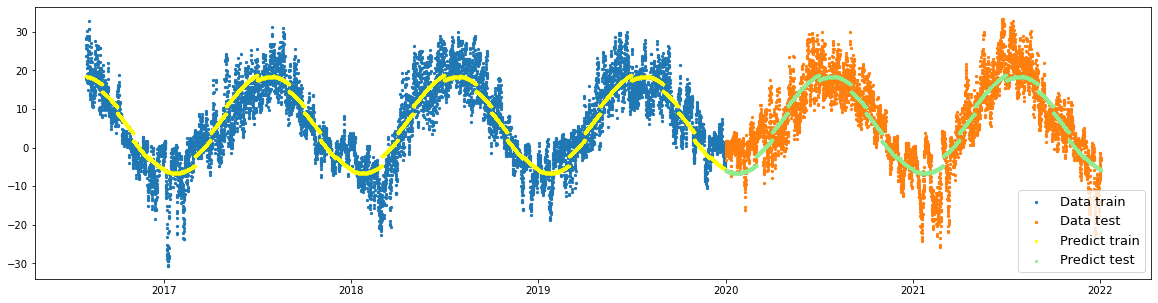

In [315]:
plt.figure(figsize=(20, 5))
plt.scatter(data_train_2['date'], y_train_2, s=5, label='Data train')
plt.scatter(data_test_2['date'], y_test_2, s=5, label='Data test')
plt.scatter(data_train_2['date'], pred_train_2, s=5, color='yellow', label='Predict train')
plt.scatter(data_test_2['date'], pred_test_2, s=5,color='lightgreen', label='Predict test')
plt.legend(loc = 'lower right', prop={'size': 13})

In [383]:
print('Mean error on training sample 2 =', mean_absolute_error(y_train_2, pred_train_2).round(2))
print('Mean error on test sample 2 =', mean_absolute_error(y_test_2, pred_test_2).round(2))

Mean error on training sample 2 = 4.01
Mean error on test sample 2 = 4.29


In [387]:
#checking the significance of coef
mod_2 = sm.OLS(y_train_2, X_train_2)
fii_2 = mod_2.fit()
p_values_2 = fii_2.summary2().tables[1]['P>|t|'].map(int)
pd.DataFrame(p_values_2)

,P>|t|
cos_dayofyear,0
sin_dayofyear,0
med_P,0
med_U,0
med_Ff,0
med_Td,0


In [447]:
score_2 = model_lin_2.score(X_train_2, y_train_2).round(2)
print(f'Coefficient of determination = {score_2}')

Coefficient of determination = 0.76


In [452]:
# The model 2 shows the same accuracy as the base model but it has more feautures thus model 2 loses.
# The model 3 uses only cos function.

In [388]:
X_train_3 = data_train[['cos_dayofyear']]
X_test_3 = data_test[['cos_dayofyear']]
y_train_3 = data_train['T']
y_test_3 = data_test['T']

In [389]:
model_lin_3 = LinearRegression()

In [390]:
model_lin_3.fit(X_train_3, y_train_3)

LinearRegression()

In [391]:
pred_train_3 = model_lin_3.predict(X_train_3)
pred_test_3 = model_lin_3.predict(X_test_3)

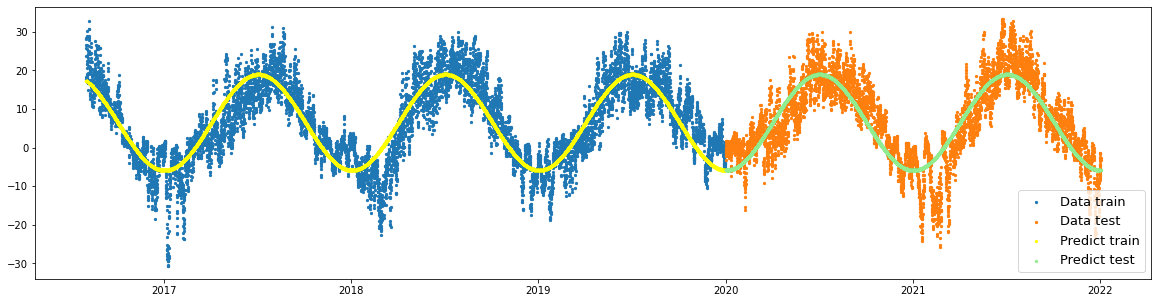

In [392]:
plt.figure(figsize=(20, 5))
plt.scatter(data_train['date'], y_train_3, s=5, label='Data train')
plt.scatter(data_test['date'], y_test_3, s=5, label='Data test')
plt.scatter(data_train['date'], pred_train_3, s=5, color='yellow', label='Predict train')
plt.scatter(data_test['date'], pred_test_3, s=5,color='lightgreen', label='Predict test')
plt.legend(loc = 'lower right', prop={'size': 13})

In [393]:
print('Mean error on training sample =', mean_absolute_error(y_train_3, pred_train_3).round(2))
print('Mean error on test sample =', mean_absolute_error(y_test_3, pred_test_3).round(2))

Mean error on training sample = 4.31
Mean error on test sample = 4.57


In [394]:
#checking the significance of coef
mod_3 = sm.OLS(y_train_3, X_train_3)
fii_3 = mod_3.fit()
p_values_3 = fii_3.summary2().tables[1]['P>|t|']
pd.DataFrame(p_values_3.map(int))

,P>|t|
cos_dayofyear,0


In [449]:
score_3 = model_lin_3.score(X_train_3, y_train_3).round(2)
print(f'Coefficient of determination = {score_3}')

Coefficient of determination = 0.71


In [ ]:
# Model 3 is less accurate than base model.

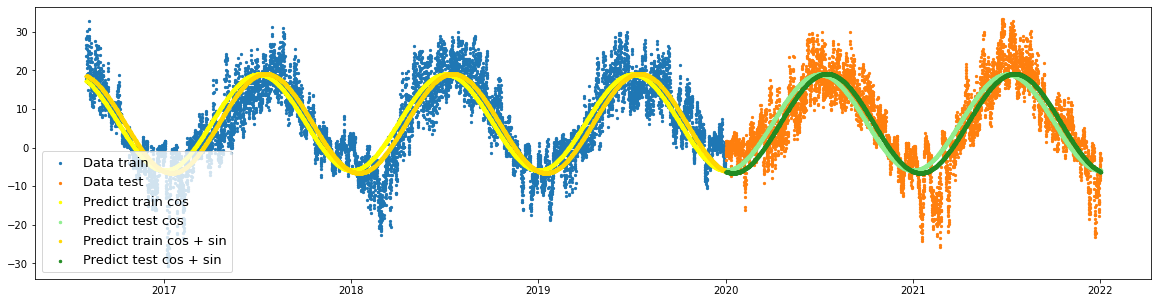

In [462]:
plt.figure(figsize=(20, 5))
plt.scatter(data_train['date'], y_train_3, s=5, label='Data train')
plt.scatter(data_test['date'], y_test_3, s=5, label='Data test')
plt.scatter(data_train['date'], pred_train_3, s=6, color='yellow', label='Predict train cos')
plt.scatter(data_test['date'], pred_test_3, s=6,color='lightgreen', label='Predict test cos')
plt.scatter(data_train['date'], pred_train, s=6, color='gold', label='Predict train cos + sin')
plt.scatter(data_test['date'], pred_test, s=6,color='forestgreen', label='Predict test cos + sin')
plt.legend(loc = 'lower left', prop={'size': 13})

In [ ]:
# The difference in dynamics of cos and sin gives us the opportunity to make the model better instead of using just cos or sin.